# Exploring upper bounds on k-mer differences based on hashes

Equiv? How long a run is the run without a hash.



In [4]:
import sourmash
import random

In [44]:
%matplotlib inline
import matplotlib.pyplot as plt

In [37]:
DNA = 'ATGC'

def generate_kmers(ksize):
    kmer = [ random.choice(DNA) for _ in range(ksize) ]
    while 1:
        random.shuffle(kmer)
        yield "".join(kmer)

In [ ]:
KSIZE = 31
SCALED = 100

runlengths = []
for i in range(int(100000)):
    if i % 1000 == 0:
        print('...', i)
    run = 0
    mh = sourmash.MinHash(n=0, ksize=KSIZE, scaled=SCALED)
    it = iter(generate_kmers(KSIZE))
    while not len(mh):
        kmer = next(it)
        mh.add_kmer(kmer)
        run += 1
    runlengths.append(run)

#print(runlengths)

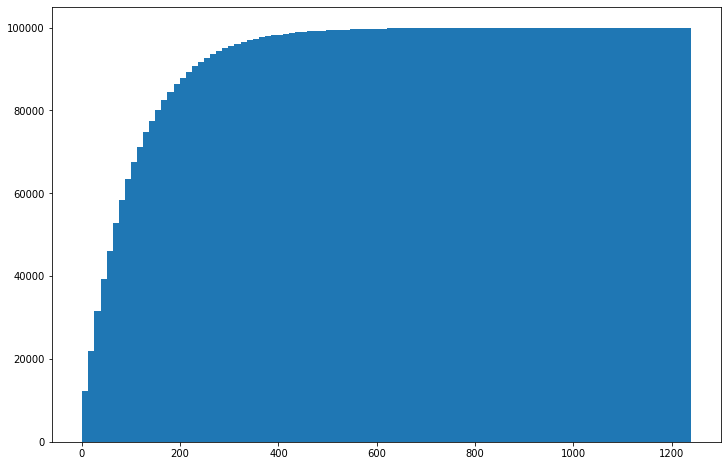

In [81]:
fig, ax = plt.subplots(figsize=(12, 8))

_ = ax.hist(runlengths, bins=100, cumulative=True)

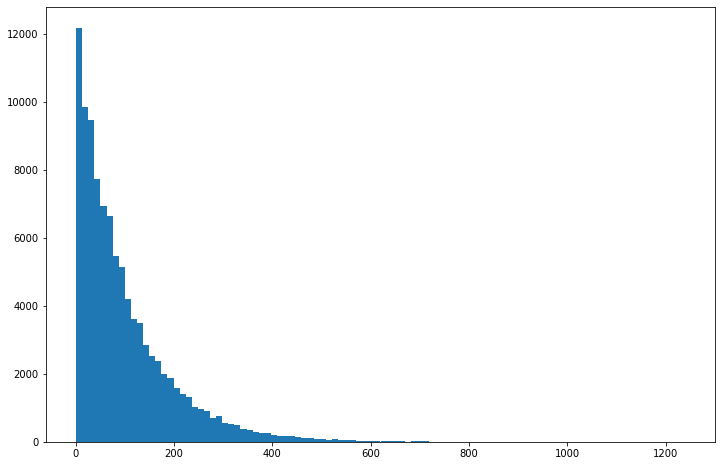

In [82]:
fig, ax = plt.subplots(figsize=(12, 8))

_ = ax.hist(runlengths, bins=100)

In [83]:
numpy.mean(runlengths)

100.32255

In [84]:
numpy.std(runlengths)

100.05102633905113

## thinking out loud

* two collections of k-mers of size N
* all hashes in common at SCALED
* what's the probability that they have no more than M different k-mers?

Intuition is that as M approaches SCALED, p <= 0.5

from poisson, as M => 5 x SCALED, p <= 0.9998 

that is, 99.98% of genomes of size N will have fewer than 5 \* SCALED k-mers different.

but... this can't be correct, this is independent of N? should it be?

yes, it only depends on SCALED? it's 1-the distribution above...

In [87]:
N_BINS = 20
n_notfound = [0] * N_BINS
for run in runlengths:
    for i in range(N_BINS):
        if run <= (i+1)*SCALED:
            n_notfound[i] += 1
            
for i in range(N_BINS):
    n_notfound[i] /= len(runlengths)

In [88]:
for i, val in enumerate(n_notfound):
    print(f"in M={(i+1) * SCALED} k-mers, p of finding at least one hash is: {val*100:.2f}% - scaled={SCALED}")

in M=100 k-mers, p of finding at least one hash is: 63.43% - scaled=100
in M=200 k-mers, p of finding at least one hash is: 86.51% - scaled=100
in M=300 k-mers, p of finding at least one hash is: 95.11% - scaled=100
in M=400 k-mers, p of finding at least one hash is: 98.18% - scaled=100
in M=500 k-mers, p of finding at least one hash is: 99.32% - scaled=100
in M=600 k-mers, p of finding at least one hash is: 99.72% - scaled=100
in M=700 k-mers, p of finding at least one hash is: 99.90% - scaled=100
in M=800 k-mers, p of finding at least one hash is: 99.96% - scaled=100
in M=900 k-mers, p of finding at least one hash is: 99.98% - scaled=100
in M=1000 k-mers, p of finding at least one hash is: 99.99% - scaled=100
in M=1100 k-mers, p of finding at least one hash is: 100.00% - scaled=100
in M=1200 k-mers, p of finding at least one hash is: 100.00% - scaled=100
in M=1300 k-mers, p of finding at least one hash is: 100.00% - scaled=100
in M=1400 k-mers, p of finding at least one hash is: 100.

## Using poisson as crosscheck

In [96]:
import math
for i in range(N_BINS):
    i = i+1
    print(f"M={i*SCALED} k-mers - p of at least one hash is: {(1 - math.exp(-i))*100:.2f}% - scaled={SCALED}")

M=100 k-mers - p of at least one hash is: 63.21% - scaled=100
M=200 k-mers - p of at least one hash is: 86.47% - scaled=100
M=300 k-mers - p of at least one hash is: 95.02% - scaled=100
M=400 k-mers - p of at least one hash is: 98.17% - scaled=100
M=500 k-mers - p of at least one hash is: 99.33% - scaled=100
M=600 k-mers - p of at least one hash is: 99.75% - scaled=100
M=700 k-mers - p of at least one hash is: 99.91% - scaled=100
M=800 k-mers - p of at least one hash is: 99.97% - scaled=100
M=900 k-mers - p of at least one hash is: 99.99% - scaled=100
M=1000 k-mers - p of at least one hash is: 100.00% - scaled=100
M=1100 k-mers - p of at least one hash is: 100.00% - scaled=100
M=1200 k-mers - p of at least one hash is: 100.00% - scaled=100
M=1300 k-mers - p of at least one hash is: 100.00% - scaled=100
M=1400 k-mers - p of at least one hash is: 100.00% - scaled=100
M=1500 k-mers - p of at least one hash is: 100.00% - scaled=100
M=1600 k-mers - p of at least one hash is: 100.00% - scale

## The theory

the probability of seeing exactly 0 hashes in a run of M k-mers with a scaled of SCALED is:

1 - the probability of seeing 0 hashes in a run of M k-mers with a scaled of SCALED,

which is 1 - Poisson(k=0, lambda=M / scaled)

which is 1 - e**(-M/scaled)

or in Python:

```
1 - math.exp(- (M/scaled))
```

which (per notebook ;) matches the distribution pretty darned well.

(the small deviations are either due to sampling statistics, or properties of murmurhash)

## Fun concluding notes

This distribution is dependent only on `M/scaled`, not `N` (size of genome).

This means for typical microbial genome sizes N=5e6 and a scaled of SCALED, there is a convenient estimate of upper bound for fraction of genome that will be different at a given scaled if all hashes are the same.


In [133]:
# FIXME

SCALED = 100
N = 5e6

for SCALED in (100, 500, 1000):
    for i in (10, 15, 20):
        M = i*SCALED
        p = (math.exp(1 - i))
        print(f"at scaled={SCALED}, ~{(p)*100:.4f}% of {N:g} bp genomes sharing all hashes are > ~{(M/N)*100:.2f}% different.")

at scaled=100, ~0.0123% of 5e+06 bp genomes sharing all hashes are > ~0.02% different.
at scaled=100, ~0.0001% of 5e+06 bp genomes sharing all hashes are > ~0.03% different.
at scaled=100, ~0.0000% of 5e+06 bp genomes sharing all hashes are > ~0.04% different.
at scaled=500, ~0.0123% of 5e+06 bp genomes sharing all hashes are > ~0.10% different.
at scaled=500, ~0.0001% of 5e+06 bp genomes sharing all hashes are > ~0.15% different.
at scaled=500, ~0.0000% of 5e+06 bp genomes sharing all hashes are > ~0.20% different.
at scaled=1000, ~0.0123% of 5e+06 bp genomes sharing all hashes are > ~0.20% different.
at scaled=1000, ~0.0001% of 5e+06 bp genomes sharing all hashes are > ~0.30% different.
at scaled=1000, ~0.0000% of 5e+06 bp genomes sharing all hashes are > ~0.40% different.


## let's rephrase

a genome difference of < 1% for 99.9% of genomes with all hashes same =>

N/SCALED hashes identical, whatever
99% of genome the same => .01 * N the same => runlength of .01 * N k-mers without a hash 

here (p = 1 - math.exp(1 - (.01 * N / SCALED))

so we want SCALED such that p =~ .001 = .01 * N / SCALED

or 
.1 = N / scaled

or 

scaled = 10 * N



here (p = 1 - math.exp(1 - (.01 * N / SCALED))
      
      
1 - p = math.exp(1 - (.01 * N / SCALED))

math.log(1-p) = 1 - (.01 * N / SCALED)

1 - math.log(1-p) = .01 * N / SCALED

SCALED = .01 * N / (1 - math.log(1-p))
      


In [147]:
.01 * N / (1 - math.log(1 - .001))

49950.02498334166

In [151]:
for N in 5e3, 5e4, 5e5, 5e6:
    N = int(N)
    print(f"for genome size {N:g}, need scaled={round(.01 * N / (1 - math.log(1 - .001)) + 0.5)} to guarantee that 99.9% of genomes with all hashes same => < 1% different")

for genome size 5000, need scaled=50 to guarantee that 99.9% of genomes with all hashes same => < 1% different
for genome size 50000, need scaled=500 to guarantee that 99.9% of genomes with all hashes same => < 1% different
for genome size 500000, need scaled=4996 to guarantee that 99.9% of genomes with all hashes same => < 1% different
for genome size 5e+06, need scaled=49951 to guarantee that 99.9% of genomes with all hashes same => < 1% different


or ...

for a given genome size N, need scaled = N/100 to guarantee that 99.9% of genomes with identical hashes are <1% different

or, back of napkin,

for p = .001, want f=>.001; .1 * N/scaled = .001 => .01 * N / scaled = 1 => scaled = N / 100

It also multiplies - for genome size 5e6 at a scaled of 5000, 99.9% of genomes with identical hashes are < 0.1% different.

(that is, divide scaled by 10 => divide difference by 10)

In [158]:
S = -5e4 / math.log(.001)
print(S)


7238.241365054198


In [171]:
for N in 5e3, 5e4, 5e5, 5e6:
    for p in .001,:
        for f in .05, .01, .001:
            N = int(N)
            print(f"for genome size {N:g}, need scaled={round(-(f * N / math.log(p)) + 0.5)} to guarantee that {p*100:.2f}% of genomes with all hashes same => < {f*100:.1f}% different")

for genome size 5000, need scaled=37 to guarantee that 0.10% of genomes with all hashes same => < 5.0% different
for genome size 5000, need scaled=8 to guarantee that 0.10% of genomes with all hashes same => < 1.0% different
for genome size 5000, need scaled=1 to guarantee that 0.10% of genomes with all hashes same => < 0.1% different
for genome size 50000, need scaled=362 to guarantee that 0.10% of genomes with all hashes same => < 5.0% different
for genome size 50000, need scaled=73 to guarantee that 0.10% of genomes with all hashes same => < 1.0% different
for genome size 50000, need scaled=8 to guarantee that 0.10% of genomes with all hashes same => < 0.1% different
for genome size 500000, need scaled=3620 to guarantee that 0.10% of genomes with all hashes same => < 5.0% different
for genome size 500000, need scaled=724 to guarantee that 0.10% of genomes with all hashes same => < 1.0% different
for genome size 500000, need scaled=73 to guarantee that 0.10% of genomes with all hashe

## crosscheck

In [176]:
1 - math.exp(-5e2 / 100)

0.9932620530009145

In [172]:
len(runlengths)

100000

In [173]:
N=5e6
f = .01
max_runlength = N*f
max_runlength

50000.0

In [179]:
def n_runs_over(runlengths, L):
    return len([ x for x in runlengths if x >= L ])

Nf = 5e2
n_runs_over(runlengths, Nf) / len(runlengths) + 1 - math.exp(-Nf / 100)

1.0001720530009146

In [182]:
def p_samehash_runlength(L, f, S):
    f = float(f)
    L = int(L)
    S = int(S)
    assert S >= 1
    assert f > 0
    assert f <= 1
    assert L > 0
    
    return math.exp(-f * L / S)



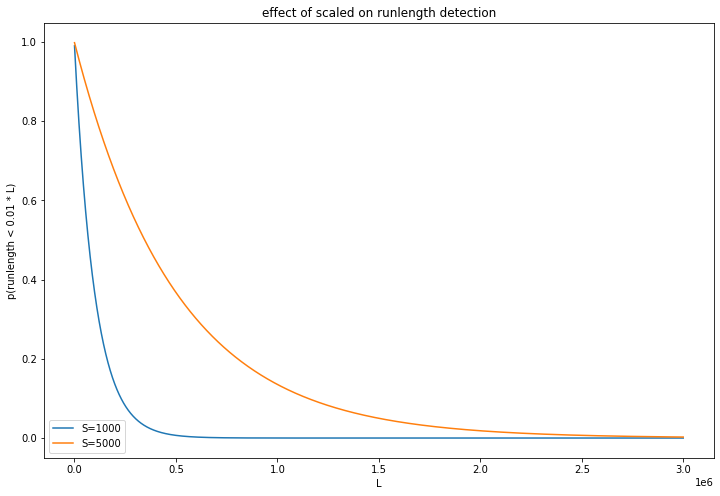

In [196]:
S = 1000
f = 0.01

xx = list(range(1000, 3000000, 1000))
yy1 = [ p_samehash_runlength(x, f, 1000) for x in xx ]
yy2 = [ p_samehash_runlength(x, f, 5000) for x in xx ]

fig, ax = plt.subplots(figsize=(12, 8))

ax.plot(xx, yy1, '-', label='S=1000')
ax.plot(xx, yy2, '-', label='S=5000')

ax.set_ylabel(f'p(runlength < {f:.2f} * L)')
ax.set_xlabel('L')
ax.set_title('effect of scaled on runlength detection')
ax.legend(loc='lower left')

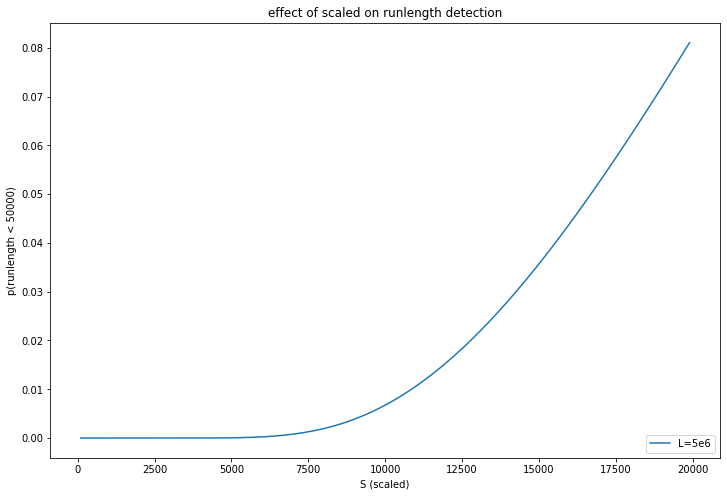

In [201]:
L = 5e6
f = 0.01

xx = list(range(100, 20000, 100))
yy1 = [ p_samehash_runlength(L, f, x) for x in xx ]

fig, ax = plt.subplots(figsize=(12, 8))

ax.plot(xx, yy1, '-', label='L=5e6')

ax.set_ylabel(f'p(runlength < {int(f*L):g})')
ax.set_xlabel('S (scaled)')
ax.set_title('effect of scaled on runlength detection')
ax.legend(loc='lower right')

In [228]:
import screed

def kmers(filename, ksize=31):
    for record in screed.open(filename):
        for start in range(0, len(record.sequence) - ksize + 1):
            yield record.sequence[start:start+ksize]

podar_runlengths = []
mh = sourmash.MinHash(0, 31, scaled=1000)

n = 0
for kmer in kmers('../sourmash/podar-ref/47.fa'):
    n += 1
    mh.add_sequence(kmer)
    if mh:
        print('...', len(podar_runlengths))
        podar_runlengths.append(n)
        n = 0
        
        mh = mh.copy_and_clear()
        
    #if n > 100000:
    #    break

... 0
... 1
... 2
... 3
... 4
... 5
... 6
... 7
... 8
... 9
... 10
... 11
... 12
... 13
... 14
... 15
... 16
... 17
... 18
... 19
... 20
... 21
... 22
... 23
... 24
... 25
... 26
... 27
... 28
... 29
... 30
... 31
... 32
... 33
... 34
... 35
... 36
... 37
... 38
... 39
... 40
... 41
... 42
... 43
... 44
... 45
... 46
... 47
... 48
... 49
... 50
... 51
... 52
... 53
... 54
... 55
... 56
... 57
... 58
... 59
... 60
... 61
... 62
... 63
... 64
... 65
... 66
... 67
... 68
... 69
... 70
... 71
... 72
... 73
... 74
... 75
... 76
... 77
... 78
... 79
... 80
... 81
... 82
... 83
... 84
... 85
... 86
... 87
... 88
... 89
... 90
... 91
... 92
... 93
... 94
... 95
... 96
... 97
... 98
... 99
... 100
... 101
... 102
... 103
... 104
... 105
... 106
... 107
... 108
... 109
... 110
... 111
... 112
... 113
... 114
... 115
... 116
... 117
... 118
... 119
... 120
... 121
... 122
... 123
... 124
... 125
... 126
... 127
... 128
... 129
... 130
... 131
... 132
... 133
... 134
... 135
... 136
... 137
... 13

... 1082
... 1083
... 1084
... 1085
... 1086
... 1087
... 1088
... 1089
... 1090
... 1091
... 1092
... 1093
... 1094
... 1095
... 1096
... 1097
... 1098
... 1099
... 1100
... 1101
... 1102
... 1103
... 1104
... 1105
... 1106
... 1107
... 1108
... 1109
... 1110
... 1111
... 1112
... 1113
... 1114
... 1115
... 1116
... 1117
... 1118
... 1119
... 1120
... 1121
... 1122
... 1123
... 1124
... 1125
... 1126
... 1127
... 1128
... 1129
... 1130
... 1131
... 1132
... 1133
... 1134
... 1135
... 1136
... 1137
... 1138
... 1139
... 1140
... 1141
... 1142
... 1143
... 1144
... 1145
... 1146
... 1147
... 1148
... 1149
... 1150
... 1151
... 1152
... 1153
... 1154
... 1155
... 1156
... 1157
... 1158
... 1159
... 1160
... 1161
... 1162
... 1163
... 1164
... 1165
... 1166
... 1167
... 1168
... 1169
... 1170
... 1171
... 1172
... 1173
... 1174
... 1175
... 1176
... 1177
... 1178
... 1179
... 1180
... 1181
... 1182
... 1183
... 1184
... 1185
... 1186
... 1187
... 1188
... 1189
... 1190
... 1191
... 1192
.

... 2034
... 2035
... 2036
... 2037
... 2038
... 2039
... 2040
... 2041
... 2042
... 2043
... 2044
... 2045
... 2046
... 2047
... 2048
... 2049
... 2050
... 2051
... 2052
... 2053
... 2054
... 2055
... 2056
... 2057
... 2058
... 2059
... 2060
... 2061
... 2062
... 2063
... 2064
... 2065
... 2066
... 2067
... 2068
... 2069
... 2070
... 2071
... 2072
... 2073
... 2074
... 2075
... 2076
... 2077
... 2078
... 2079
... 2080
... 2081
... 2082
... 2083
... 2084
... 2085
... 2086
... 2087
... 2088
... 2089
... 2090
... 2091
... 2092
... 2093
... 2094
... 2095
... 2096
... 2097
... 2098
... 2099
... 2100
... 2101
... 2102
... 2103
... 2104
... 2105
... 2106
... 2107
... 2108
... 2109
... 2110
... 2111
... 2112
... 2113
... 2114
... 2115
... 2116
... 2117
... 2118
... 2119
... 2120
... 2121
... 2122
... 2123
... 2124
... 2125
... 2126
... 2127
... 2128
... 2129
... 2130
... 2131
... 2132
... 2133
... 2134
... 2135
... 2136
... 2137
... 2138
... 2139
... 2140
... 2141
... 2142
... 2143
... 2144
.

... 2987
... 2988
... 2989
... 2990
... 2991
... 2992
... 2993
... 2994
... 2995
... 2996
... 2997
... 2998
... 2999
... 3000
... 3001
... 3002
... 3003
... 3004
... 3005
... 3006
... 3007
... 3008
... 3009
... 3010
... 3011
... 3012
... 3013
... 3014
... 3015
... 3016
... 3017
... 3018
... 3019
... 3020
... 3021
... 3022
... 3023
... 3024
... 3025
... 3026
... 3027
... 3028
... 3029
... 3030
... 3031
... 3032
... 3033
... 3034
... 3035
... 3036
... 3037
... 3038
... 3039
... 3040
... 3041
... 3042
... 3043
... 3044
... 3045
... 3046
... 3047
... 3048
... 3049
... 3050
... 3051
... 3052
... 3053
... 3054
... 3055
... 3056
... 3057
... 3058
... 3059
... 3060
... 3061
... 3062
... 3063
... 3064
... 3065
... 3066
... 3067
... 3068
... 3069
... 3070
... 3071
... 3072
... 3073
... 3074
... 3075
... 3076
... 3077
... 3078
... 3079
... 3080
... 3081
... 3082
... 3083
... 3084
... 3085
... 3086
... 3087
... 3088
... 3089
... 3090
... 3091
... 3092
... 3093
... 3094
... 3095
... 3096
... 3097
.

... 3905
... 3906
... 3907
... 3908
... 3909
... 3910
... 3911
... 3912
... 3913
... 3914
... 3915
... 3916
... 3917
... 3918
... 3919
... 3920
... 3921
... 3922
... 3923
... 3924
... 3925
... 3926
... 3927
... 3928
... 3929
... 3930
... 3931
... 3932
... 3933
... 3934
... 3935
... 3936
... 3937
... 3938
... 3939
... 3940
... 3941
... 3942
... 3943
... 3944
... 3945
... 3946
... 3947
... 3948
... 3949
... 3950
... 3951
... 3952
... 3953
... 3954
... 3955
... 3956
... 3957
... 3958
... 3959
... 3960
... 3961
... 3962
... 3963
... 3964
... 3965
... 3966
... 3967
... 3968
... 3969
... 3970
... 3971
... 3972
... 3973
... 3974
... 3975
... 3976
... 3977
... 3978
... 3979
... 3980
... 3981
... 3982
... 3983
... 3984
... 3985
... 3986
... 3987
... 3988
... 3989
... 3990
... 3991
... 3992
... 3993
... 3994
... 3995
... 3996
... 3997
... 3998
... 3999
... 4000
... 4001
... 4002
... 4003
... 4004
... 4005
... 4006
... 4007
... 4008
... 4009
... 4010
... 4011
... 4012
... 4013
... 4014
... 4015
.

... 4842
... 4843
... 4844
... 4845
... 4846
... 4847
... 4848
... 4849
... 4850
... 4851
... 4852
... 4853
... 4854
... 4855
... 4856
... 4857
... 4858
... 4859
... 4860
... 4861
... 4862
... 4863
... 4864
... 4865
... 4866
... 4867
... 4868
... 4869
... 4870
... 4871
... 4872
... 4873
... 4874
... 4875
... 4876
... 4877
... 4878
... 4879
... 4880
... 4881
... 4882
... 4883
... 4884
... 4885
... 4886
... 4887
... 4888
... 4889
... 4890
... 4891
... 4892
... 4893
... 4894
... 4895
... 4896
... 4897
... 4898
... 4899
... 4900
... 4901
... 4902
... 4903
... 4904
... 4905
... 4906
... 4907
... 4908
... 4909
... 4910
... 4911
... 4912
... 4913
... 4914
... 4915
... 4916
... 4917
... 4918
... 4919
... 4920
... 4921
... 4922
... 4923
... 4924
... 4925
... 4926
... 4927
... 4928
... 4929
... 4930
... 4931
... 4932
... 4933
... 4934
... 4935
... 4936
... 4937
... 4938
... 4939
... 4940
... 4941
... 4942
... 4943
... 4944
... 4945
... 4946
... 4947
... 4948
... 4949
... 4950
... 4951
... 4952
.

In [229]:
print(sum(podar_runlengths))

5312680


In [230]:
numpy.mean(podar_runlengths)

1003.9077853363567

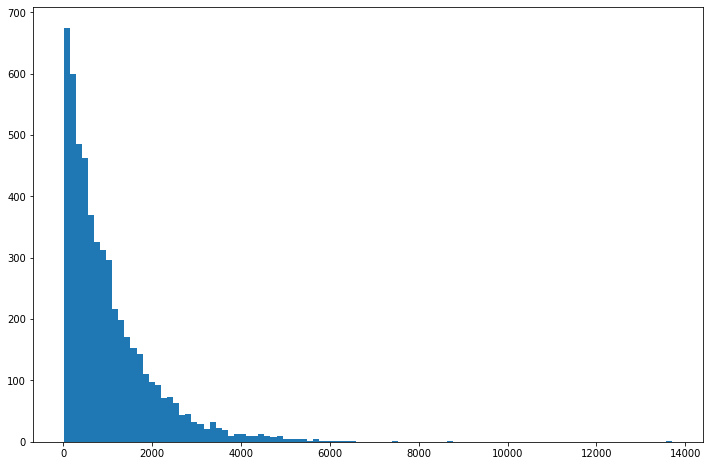

In [232]:
fig, ax = plt.subplots(figsize=(12, 8))

_ = ax.hist(podar_runlengths, bins=100)
#ax.set_xlim(0, 2000)